In [ ]:
# !pip -q install pydantic
# !pip -q install --upgrade aixplain
# !pip -q install datasets scikit-learn

In [ ]:
# install the libraries: pip install pandas scipy scikit-learn datasets seaborn matplotlib

import os
import pandas as pd
from datasets import load_dataset

os.environ["TEAM_API_KEY"] = "TEAM_API_KEY"
from aixplain.factories import AgentFactory, TeamAgentFactory
from utils import *

In [2]:
dataset = load_dataset("fever/feverous", trust_remote_code=True)
df_val = pd.DataFrame(dataset["validation"])

In [6]:
ROLE = """You are an AI fact verification agent trained to research, analyze claims, and classify them into specified categories.

You have access to search tools to explore the web and verify claims. If ethical concerns arise with the input, classify the task as **NOT_SOLVABLE** and provide a clear explanation of the issue.

Always adhere strictly to the provided output format.

Output format:
```json
{{
  "classification": "Answer",
  "evidence": "A concise explanation of how the evidence supports the classification."
}}
```"""

In [7]:
PROMPT="""Analyze and classify the claim below using the outlined architecture:

    0: The evidence explicitly supports the claim as true.
    1: The evidence explicitly refutes or contradicts the claim.
    2: The evidence is insufficient, ambiguous, or lacks enough information to verify the claim.

Claim: {query}

Provide your response strictly in the required ***JSON format***:"""

In [ ]:
agent = AgentFactory.create(
                    name="Search and Fact Verification Assistant",
                    description=ROLE,
                    instructions=ROLE,
                    llm_id="669a63646eb56306647e1091",
                    tools=[AgentFactory.create_model_tool(model="6736411cf127849667606689"), # Tavily search
                           ],
                )

In [ ]:
n=20
answer_single = []
for idx, row in enumerate(df_val["claim"][:n]):
    query = row.replace("–", "-")
    inp = PROMPT.format(query=query) 
    response = agent.run(str(inp))
    answer_single.append(response.data.output)
    
    response_dir = "single_results"
    os.makedirs(response_dir, exist_ok=True)
    response_path = os.path.join(response_dir, f"response_{idx}.json")

    safe_dump_response_step(response, response_path)
        

In [7]:
print(len(answer_single))
answer_single

20


["{'query': {'classification': '2', 'evidence': 'The evidence discusses the Lindenbaum-Tarski algebra and its relation to various logical systems, but it does not clearly confirm or deny the specific claim about the five logical systems or the inclusion of Physics and Nodal algebra.'}}",
 "{'query': {'classification': '0', 'evidence': 'The evidence confirms that Aramais Yepiskoposyan played for FC Ararat Yerevan from 1986 to 1991, as stated in multiple sources.'}}",
 '{\'query\': {\'classification\': \'1\', \'evidence\': "The evidence confirms that \'The Discoverie of Witchcraft\' was indeed published by Reginald Scot in 1584, contradicting the claim that it was never published. Additionally, the evidence does not mention the dedications, which leaves that part of the claim unverified."}}',
 "{'query': {'classification': '0', 'evidence': 'The evidence confirms that Family Guy features five main voice actors and includes recurring cast members such as H. Jon Benjamin, Johnny Brennan, an

In [23]:
res = extract_classifications(answer_single)
res

[2, 0, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 1, 1, 1, 1, 0, 0, 1]

In [24]:
print(list(df_val[:n]["label"]))

[1, 0, 1, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1]


In [25]:
true_labels = df_val[:n]["label"].tolist()
predicted_labels = res
calculate_accuracy(true_labels, predicted_labels)

Accuracy: 75.00%


0.75

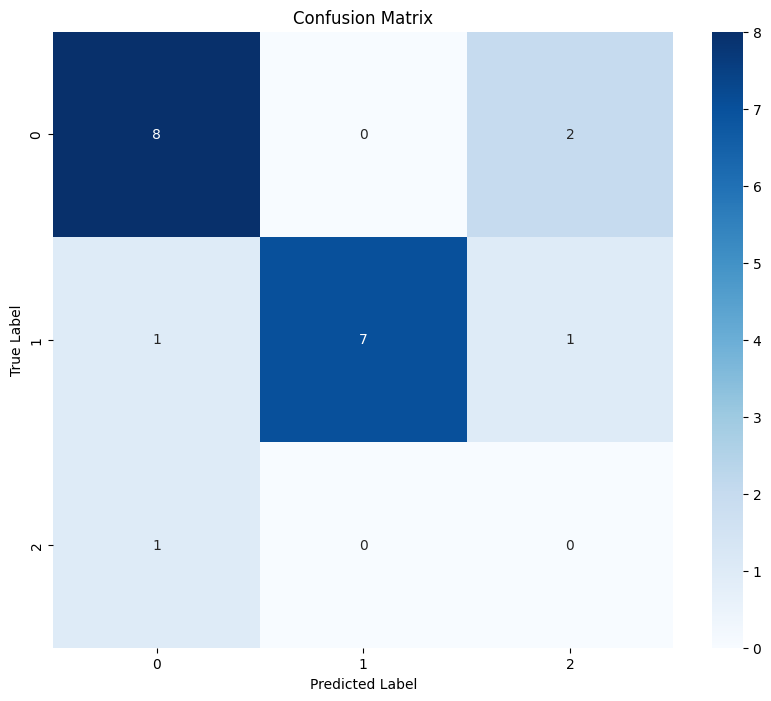

Accuracy: 75.00%
F1-Score: 0.7937

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       1.00      0.78      0.88         9
           2       0.00      0.00      0.00         1

    accuracy                           0.75        20
   macro avg       0.60      0.53      0.56        20
weighted avg       0.85      0.75      0.79        20



(0.75, 0.79375)

In [12]:
calculate_metrics(true_labels, predicted_labels)

In [13]:
save_predictions(answer_single, "prediction_single.csv", "pred")

File 'prediction_single.csv' created with column 'pred'.


Multi Agent

In [ ]:
# Multi Agent
extract_agent = AgentFactory.create(
                    name="Fact Extraction Agent",
                    description="You are an AI tasked with the extraction of relevant fact based on the user query from the internet using google search engines.",
                    instructions="You are an AI tasked with the extraction of relevant fact based on the user query from the internet using google search engines.",
                    llm_id="669a63646eb56306647e1091",
                    tools=[AgentFactory.create_model_tool(model="6736411cf127849667606689"), # Tavily search
                           ],
                )

# This agent can be optional. The multi-agent still works fine without it.
fact_agent = AgentFactory.create(
                    name="Fact Verification and Label Assignment Agent",
                    description="You are an AI responsible for verifying facts extracted from searches and assigning labels to them based on their alignment with the user's query, then outputting the labeled results.",
                    instructions="You are an AI responsible for verifying facts extracted from searches and assigning labels to them based on their alignment with the user's query, then outputting the labeled results.",
                    llm_id="669a63646eb56306647e1091",
                    tools=[],
                )

In [ ]:
community = TeamAgentFactory.create(
                        name="Search and Fact Verification Assistant",
                        agents=[extract_agent, fact_agent],
                        description=ROLE, 
                        use_mentalist = False,
                        use_inspector = False,
                        llm_id="669a63646eb56306647e1091",
                        # num_inspectors = 1,
                        # inspector_targets = ["steps"]
                    )

In [ ]:
answer_multi = []
n=20
for idx, row in enumerate(df_val["claim"][:n]):
    query = row.replace("–", "-")
    inp = PROMPT.format(query=query) 
    response = community.run(inp)
    answer_multi.append(response.data.output)
        
    response_dir = "multi_results"
    os.makedirs(response_dir, exist_ok=True)
    response_path = os.path.join(response_dir, f"response_{idx}.json")

    safe_dump_response_step(response, response_path)


In [25]:
print(len(answer_multi))
answer_multi

20


['```json\n{\n  "claim": "Algebraic logic has five Logical system and Lindenbaum-Tarski algebra which includes Physics algebra and Nodal algebra.",\n  "classification": 2,\n  "justification": "The evidence is insufficient, ambiguous, or lacks enough information to verify the claim. While the Lindenbaum-Tarski algebra is a recognized structure in algebraic logic, the specific assertion regarding five logical systems and the inclusion of Physics and Nodal algebra does not have clear support in the existing literature."\n}\n```',
 '```json\n{\n  "claim": "Aramais Yepiskoposyan played for FC Ararat Yerevan, an Armenian football club based in Yerevan during 1986 to 1991.",\n  "classification": 0,\n  "justification": "The evidence explicitly supports the claim as true."\n}\n```',
 '```json\n{\n  "claim": "Scot\'s book is titled The Discoverie of Witchcraft, and was never published at the end the printer gives his name, there are also four dedications one of which is to Sir Roger Manwood.",\n

In [17]:
res = extract_classifications(answer_multi)
res

[2, 0, 1, 0, 0, 1, 1, 2, 0, 2, 0, 0, 2, 1, 0, 1, 1, 0, 0, 1]

In [22]:
print(list(df_val[:n]["label"]))

[1, 0, 1, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1]


In [19]:
true_labels = df_val[:n]["label"].tolist()
predicted_labels = res
calculate_accuracy(true_labels, predicted_labels)

Accuracy: 65.00%


0.65

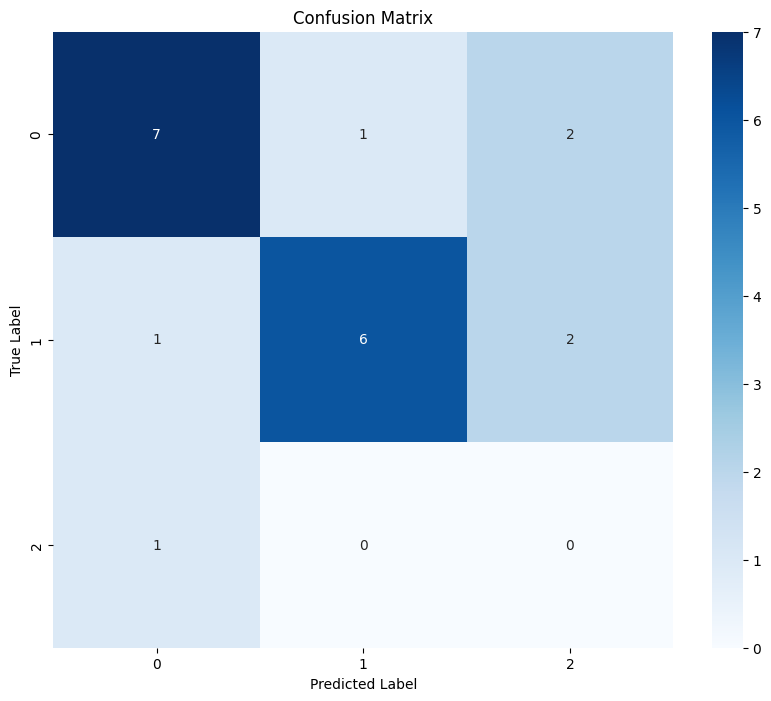

Accuracy: 65.00%
F1-Score: 0.7059

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.86      0.67      0.75         9
           2       0.00      0.00      0.00         1

    accuracy                           0.65        20
   macro avg       0.54      0.46      0.50        20
weighted avg       0.77      0.65      0.71        20



(0.65, 0.7059210526315789)

In [20]:
true_labels = df_val[:n]["label"].tolist()
predicted_labels = res
calculate_metrics(true_labels, predicted_labels)

In [21]:
save_predictions(answer_multi, "prediction_multi.csv", "pred")

File 'prediction_multi.csv' created with column 'pred'.
